In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import yfinance as yf
import mplfinance as mpf
import ta
import seaborn as sns
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasRegressor
from keras.regularizers import l2
from keras.layers import LSTM,Dense,Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import BatchNormalization
from sklearn.metrics import r2_score

In [2]:
start = '2015-01-01'
end = '2020-07-30'
ticker = 'K'
index= '^GSPC'
interval = "1d"

In [3]:
prediction_interval = 1

In [4]:

df =yf.download(ticker,start,end,interval)
ind =yf.download(index,start,end,interval)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [5]:
df.head()

,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits
Date,,,,,,,,
2015-01-02,65.629997,66.139999,65.089996,65.480003,53.926277,846800,0.0,0
2015-01-05,65.239998,65.370003,64.139999,64.260002,52.921539,1360200,0.0,0
2015-01-06,64.529999,65.089996,64.209999,64.449997,53.078014,2198100,0.0,0
2015-01-07,65.099998,66.089996,65.070000,66.010002,54.362762,1683400,0.0,0
2015-01-08,66.480003,67.250000,66.370003,67.209999,55.351021,1422800,0.0,0


In [6]:
#generating return columns
df['r'] =df['Adj Close'].pct_change(prediction_interval)*100
df.drop(['Dividends','Stock Splits'],axis=1,inplace=True)
df.dropna(inplace=True)

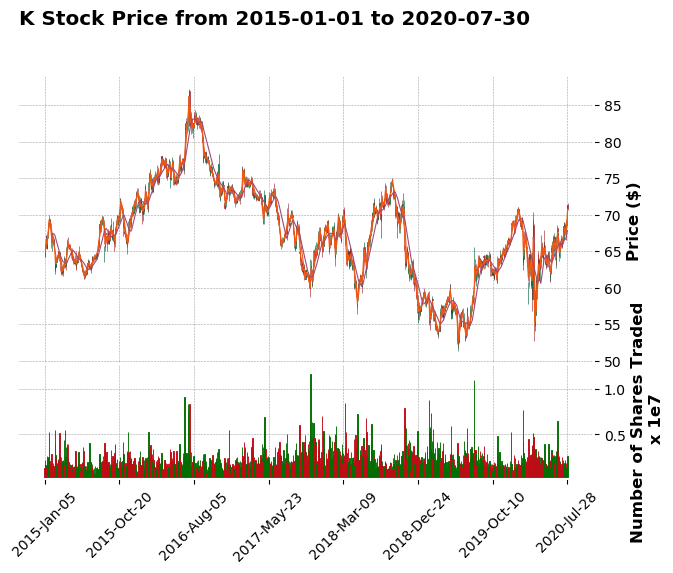

In [7]:
# Visualizing the stock price and volume

mpf.plot(df, type='candle', style='charles',
            title=ticker+' Stock Price from '+start+' to '+end ,
            ylabel='Price ($)',
            ylabel_lower='Number of Shares Traded',
            volume=True, 
            mav=(3,6,20), 
           )
plt.show()

In [8]:
# data summary
df

,Open,High,Low,Close,Adj Close,Volume,r
Date,,,,,,,
2015-01-05,65.239998,65.370003,64.139999,64.260002,52.921539,1360200,-1.863169
2015-01-06,64.529999,65.089996,64.209999,64.449997,53.078014,2198100,0.295674
2015-01-07,65.099998,66.089996,65.070000,66.010002,54.362762,1683400,2.420490
2015-01-08,66.480003,67.250000,66.370003,67.209999,55.351021,1422800,1.817896
2015-01-09,67.150002,67.150002,66.339996,66.430000,54.708656,1352000,-1.160529
...,...,...,...,...,...,...,...
2020-07-23,67.669998,68.480003,67.660004,68.410004,67.247910,1425900,1.408251
2020-07-24,68.650002,69.209999,67.849998,68.680000,67.513321,1217000,0.394676
2020-07-27,68.500000,70.099998,68.500000,69.970001,68.781403,2354900,1.878269


In [9]:
# data information summary
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1402 entries, 2015-01-05 to 2020-07-29
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1402 non-null   float64
 1   High       1402 non-null   float64
 2   Low        1402 non-null   float64
 3   Close      1402 non-null   float64
 4   Adj Close  1402 non-null   float64
 5   Volume     1402 non-null   int64  
 6   r          1402 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 87.6 KB


In [10]:
# index data information summary
ind.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1403 entries, 2015-01-02 to 2020-07-29
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1403 non-null   float64
 1   High          1403 non-null   float64
 2   Low           1403 non-null   float64
 3   Close         1403 non-null   float64
 4   Adj Close     1403 non-null   float64
 5   Volume        1403 non-null   int64  
 6   Dividends     1403 non-null   int64  
 7   Stock Splits  1403 non-null   int64  
dtypes: float64(5), int64(3)
memory usage: 98.6 KB


In [11]:
# As seen from information summaries there is no missing value in data sets,however there is a disparity between stock data lenth and 
#index data lenth which comes from dropping the nan values after generating return in stock data. Our goal using index data 
# in stock price prediction, therefore  index data should be used one prediction_interval from back after dropping the disparity row
ind = ind.iloc[1:,:]
df['ind_close_shifted_back'] = ind['Adj Close']
df.dropna(inplace=True)


In [12]:
# data descriptive summary
df.describe()

,Open,High,Low,Close,Adj Close,Volume,r,ind_close_shifted_back
count,1402.000000,1402.000000,1402.000000,1402.000000,1402.000000,1.402000e+03,1402.000000,1402.000000
mean,67.357568,67.929151,66.800014,67.382154,60.267225,2.284562e+06,0.028247,2511.823886
std,6.390736,6.366758,6.428655,6.396123,5.089404,1.178893e+06,1.406815,389.934079
min,51.450001,52.720001,51.340000,52.090000,48.861458,3.748000e+05,-10.919369,1829.079956
25%,63.275001,63.880001,62.612500,63.242501,55.813705,1.536300e+06,-0.598855,2110.410034
50%,66.970001,67.489998,66.344997,66.969997,60.779940,1.990650e+06,0.070966,2501.410034
75%,71.910004,72.389999,71.465000,71.917500,64.121881,2.708750e+06,0.659298,2832.105042
max,86.900002,87.160004,85.400002,86.980003,74.812561,1.159840e+07,10.645785,3386.149902


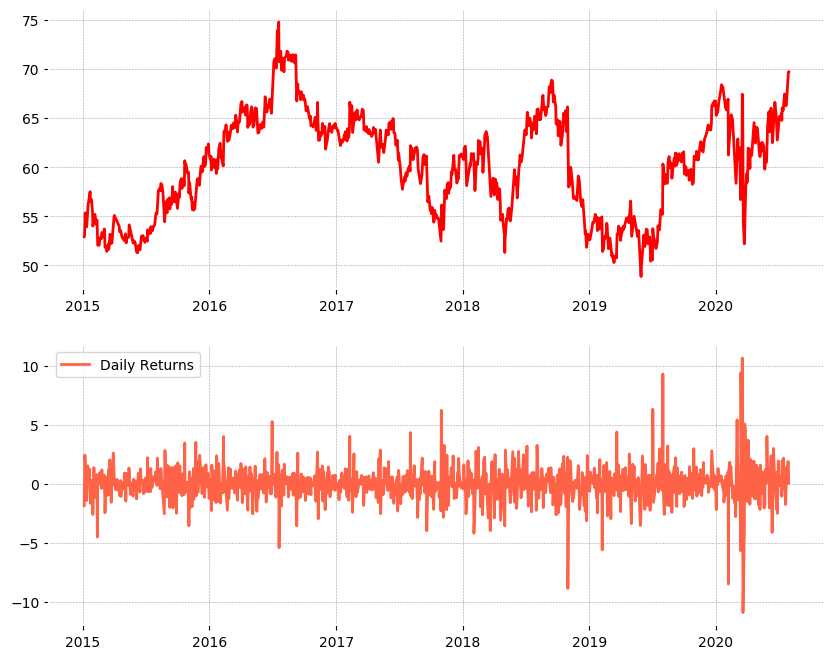

In [13]:
# Plotting Stock Price and Return
fig = plt.figure(figsize=(10, 8))
ax1=plt.subplot(2, 1, 1)
ax1.plot(df.index, df['Adj Close'].values,color = 'red', label = 'Daily Prices')
ax2=plt.subplot(2, 1, 2)
ax2.plot(df.index, df['r'].values,color = 'tomato', label = 'Daily Returns')
plt.legend(loc = 'best')
plt.show()

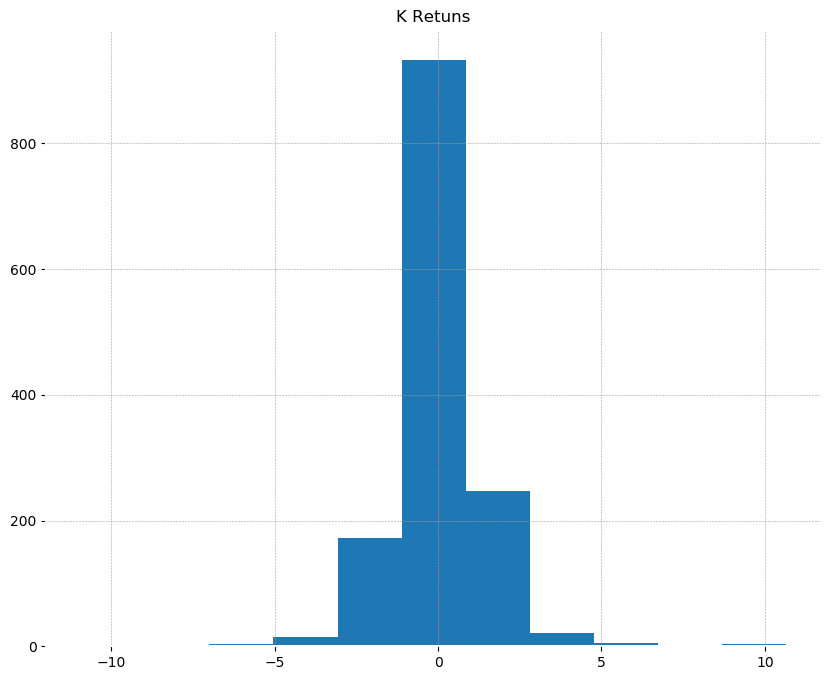

In [14]:
# the stock retun distribution
bins = int(round(1 + (3.322*np.log10(len(df)))))

fig= plt.figure(figsize=(10,8))
plt.hist(df['r'].values,bins=bins)
plt.xlabel = 'Returns'
plt.ylabel = 'Frequency'
plt.title(ticker+' Retuns')
plt.show()

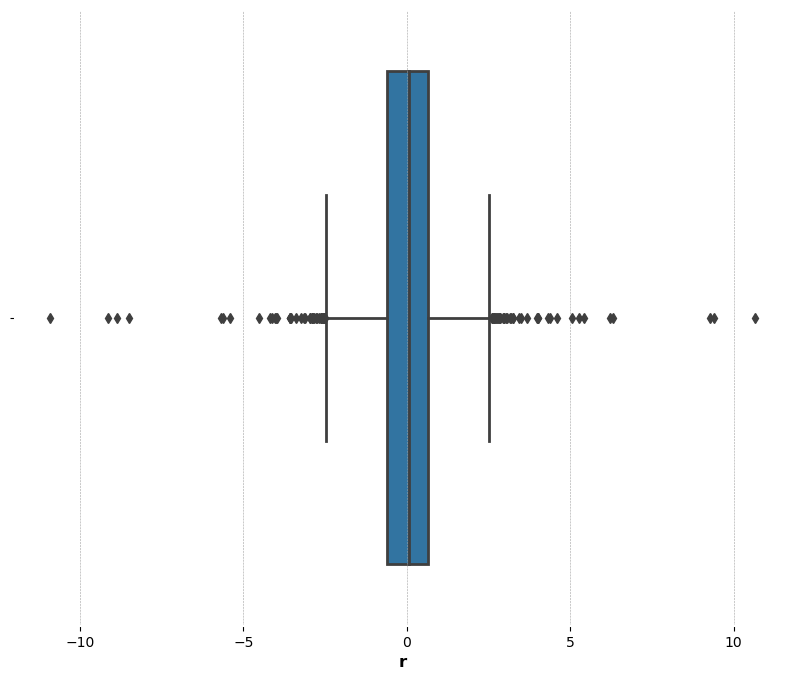

In [15]:
# Visualizing descriptive stock return statistics
fig= plt.figure(figsize=(10,8))
sns.boxplot(x=df['r'])
plt.show()

In [16]:
# variables from technical analysis 
df['ema_21'] = ta.trend.EMAIndicator(close=df['Adj Close'], n=21, fillna=False).ema_indicator()
df['ema_200'] =ta.trend.EMAIndicator(close=df['Adj Close'], n=200, fillna=False).ema_indicator()
df['VWAP_5'] = ta.volume.VolumeWeightedAveragePrice(high=df['High'], low=df['Low'], close=df['Adj Close'], volume=df['Volume'], n = 5, fillna= False).volume_weighted_average_price()
df['VWAP_20'] = ta.volume.VolumeWeightedAveragePrice(high=df['High'], low=df['Low'], close=df['Adj Close'], volume=df['Volume'], n = 20, fillna= False).volume_weighted_average_price()
df['stoch_oscill_14'] = ta.momentum.StochasticOscillator(high=df['High'],low=df['Low'],close=df['Adj Close'], n=14, d_n=3, fillna=False).stoch()
df['tsi'] = ta.momentum.TSIIndicator(close=df['Adj Close'],r=20,s=5,fillna=False).tsi()
df['willr_14'] = ta.momentum.WilliamsRIndicator(high=df['High'],low=df['Low'],close=df['Adj Close'],lbp= 14).wr()
df['aws_osl'] = ta.momentum.ao(high=df['High'],low=df['Low'],s=5,len=20, fillna=False)
df['ult_osl'] = ta.momentum.uo(high=df['High'],low=df['Low'],close=df['Adj Close'],s=7, m=14, len=28, ws=4.0, wm=2.0, wl=1.0, fillna=False)
df['acc'] = ta.volume.AccDistIndexIndicator(high=df['High'],low=df['Low'],close=df['Adj Close'],volume=df['Volume'], fillna= False).acc_dist_index()
df['cmf_20'] = ta.volume.ChaikinMoneyFlowIndicator(high=df['High'],low=df['Low'],close=df['Adj Close'],volume=df['Volume'], n= 20, fillna= False).chaikin_money_flow() 
df['mfi_5'] = ta.volume.MFIIndicator(high=df['High'],low=df['Low'],close=df['Adj Close'],volume=df['Volume'], n= 5, fillna= False).money_flow_index()  
df['mfi_14'] = ta.volume.MFIIndicator(high=df['High'],low=df['Low'],close=df['Adj Close'],volume=df['Volume'], n= 14, fillna= False).money_flow_index()  
df['obv'] = ta.volume.OnBalanceVolumeIndicator(close=df['Adj Close'],volume=df['Volume'],fillna= False).on_balance_volume()
df['vpt'] = ta.volume.VolumePriceTrendIndicator(close=df['Adj Close'],volume=df['Volume'], fillna= False).volume_price_trend()
df['vol_weig_av_p_14'] = ta.volume.VolumeWeightedAveragePrice(high=df['High'],low=df['Low'],close=df['Adj Close'], volume=df['Volume'], n= 14, fillna= False).volume_weighted_average_price()
df['vol_for_in'] = ta.volume.ForceIndexIndicator(close=df['Adj Close'], volume=df['Volume'], n=5, fillna=False).force_index() 
df['neg_vol_ind'] = ta.volume.NegativeVolumeIndexIndicator(close=df['Adj Close'], volume=df['Volume'],fillna=False).negative_volume_index()
df['vpt'] = ta.volume.VolumePriceTrendIndicator(close=df['Adj Close'],volume=df['Volume'], fillna= False).volume_price_trend()
df['atr_10'] = ta.volatility.AverageTrueRange(high=df['High'],low=df['Low'],close=df['Adj Close'], n= 10, fillna= False).average_true_range()
df['adx_14'] = ta.trend.ADXIndicator(high=df['High'],low=df['Low'],close=df['Adj Close'], n=14, fillna= False).adx()
df ['aroon_20'] = ta.trend.AroonIndicator(close=df['Adj Close'], n= 20, fillna = False).aroon_indicator()
df ['cci_10'] =ta.trend.CCIIndicator(high=df['High'],low=df['Low'],close=df['Adj Close'], n= 10, c= 0.015, fillna= False).cci()
df ['cci_5'] =ta.trend.CCIIndicator(high=df['High'],low=df['Low'],close=df['Adj Close'], n= 5, c= 0.015, fillna= False).cci()
df['macd_20_10'] = ta.trend.MACD(close=df['Adj Close'],n_slow= 20, n_fast= 10, n_sign=7, fillna= False).macd()
df['mass'] = ta.trend.MassIndex(high=df['High'],low=df['Low'], n= 5, n2= 15, fillna= False).mass_index() 
df['psar'] = ta.trend.PSARIndicator(high=df['High'],low=df['Low'],close=df['Adj Close'], step= 0.02, max_step= 0.2, fillna= False).psar()
df['trix_10'] = ta.trend.TRIXIndicator(close=df['Adj Close'], n= 10, fillna= False).trix()
df['vortex_10'] =ta.trend.VortexIndicator(high=df['High'],low=df['Low'],close=df['Adj Close'],n=10, fillna= False).vortex_indicator_diff()
df['acc'] =ta.volume.acc_dist_index(high=df['High'],low=df['Low'],close=df['Adj Close'],volume=df['Volume'], fillna= False)
df['vol_for_in'] =ta.volume.force_index(close=df['Adj Close'], volume=df['Volume'], n=5, fillna=False)
df['obv'] = ta.volume.on_balance_volume(close=df['Adj Close'],volume=df['Volume'],fillna= False)


In [17]:
# dropping nan values
df.dropna(inplace=True)

In [18]:
# Generating mid_point_level price (target) to make more accurate prediction
df_n = pd.DataFrame((df['High']+df['Low'])/2)
df_n['high_low_dif_per'] = (df['High']-df['Low'])/df['Adj Close']
df_n.columns = ['mid_point_price','high_low_dif_per']

In [19]:
# Finalizing dataframe
df =  pd.concat([df_n,df],axis=1)

In [20]:
df['target'] = df['mid_point_price']
df.dropna(inplace=True)

In [21]:
#Revealing and removing the outliers 
std = np.std(df['r'])
print(round(std,4))
df['z_score']=stats.zscore(df['r'])

df = df.loc[df['z_score'].abs()<=3]

1.463


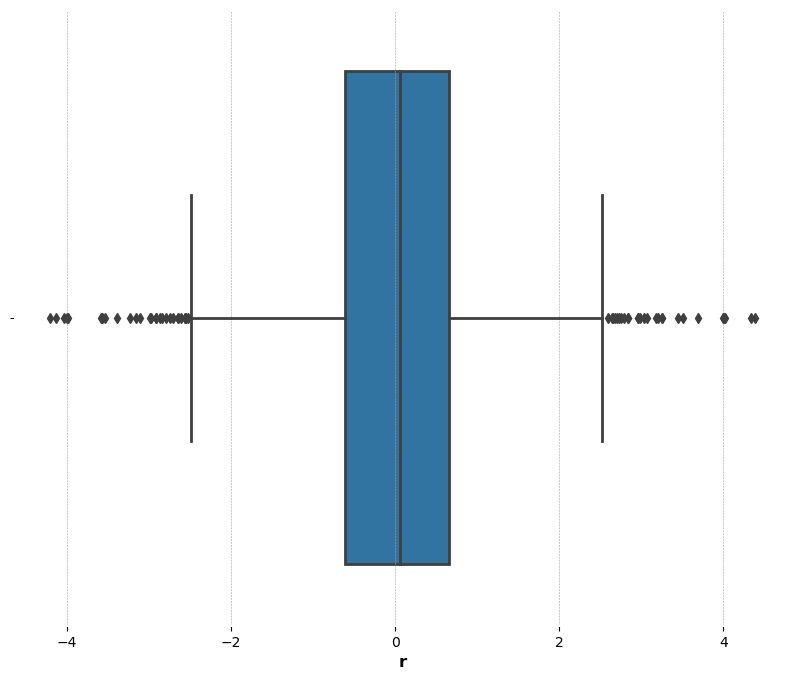

In [22]:
# Visualizing descriptive stock return statistics after removing outliers
fig= plt.figure(figsize=(10,8))
sns.boxplot(x=df['r'])
plt.show()

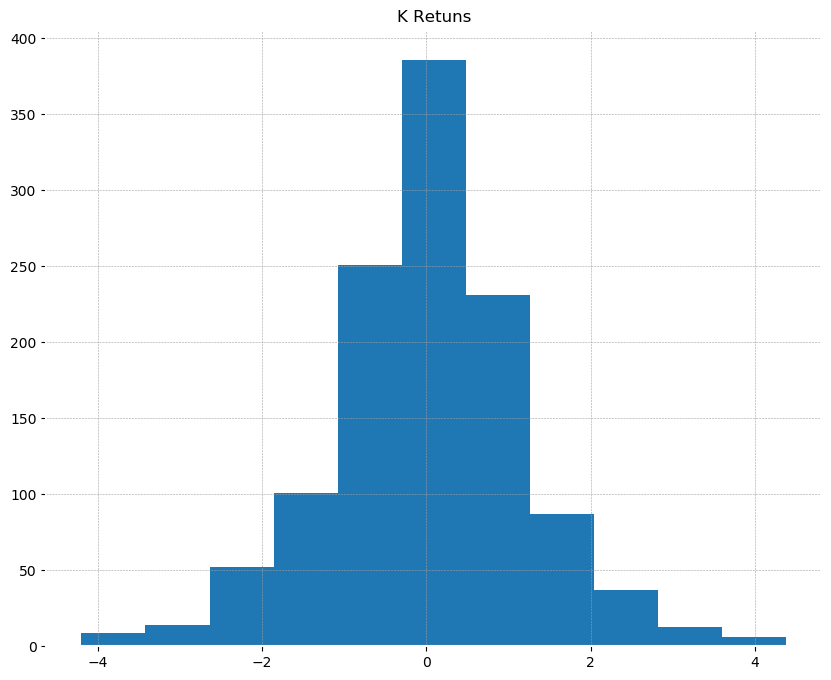

In [23]:
# Stock return distiribution after removing outliers
fig= plt.figure(figsize=(10,8))
plt.hist(df['r'].values,bins=bins)
plt.xlabel = 'r'
plt.ylabel = 'Frequency'
plt.title(ticker+' Retuns')
plt.show()

In [24]:
# Calculate returns

print(ticker+' Daily Average Return: ', '{:.2f}%'.format(df['r'].mean()))
print(ticker+' Monthly Average Return: ', '{:.2f}%'.format((df['Adj Close'].resample('BM').last().pct_change(prediction_interval)*100).mean()))
print(ticker+' Annual Average Return: ', '{:.2f}%'.format((df['Adj Close'].resample('BA').last().pct_change(prediction_interval)*100).mean()))

K Daily Average Return:  0.02%
K Monthly Average Return:  0.43%
K Annual Average Return:  3.41%


In [25]:
# Calculate stds of returns
std_daily_return = df['r'].std()
print(ticker+' Daily Volatility: ', '{:.2f}%'.format(std_daily_return))
print(ticker+' Monthly Volatility: ', '{:.2f}%'.format(np.sqrt(21)*std_daily_return))
print(ticker+' Annual Volatility: ', '{:.2f}%'.format(np.sqrt(252)*std_daily_return))

K Daily Volatility:  1.18%
K Monthly Volatility:  5.42%
K Annual Volatility:  18.77%


In [26]:
# Dropping irrelavent and same class variables
df.drop(['Low','High','Open','Close', 'Adj Close','z_score', 'r'],axis=1,inplace=True)

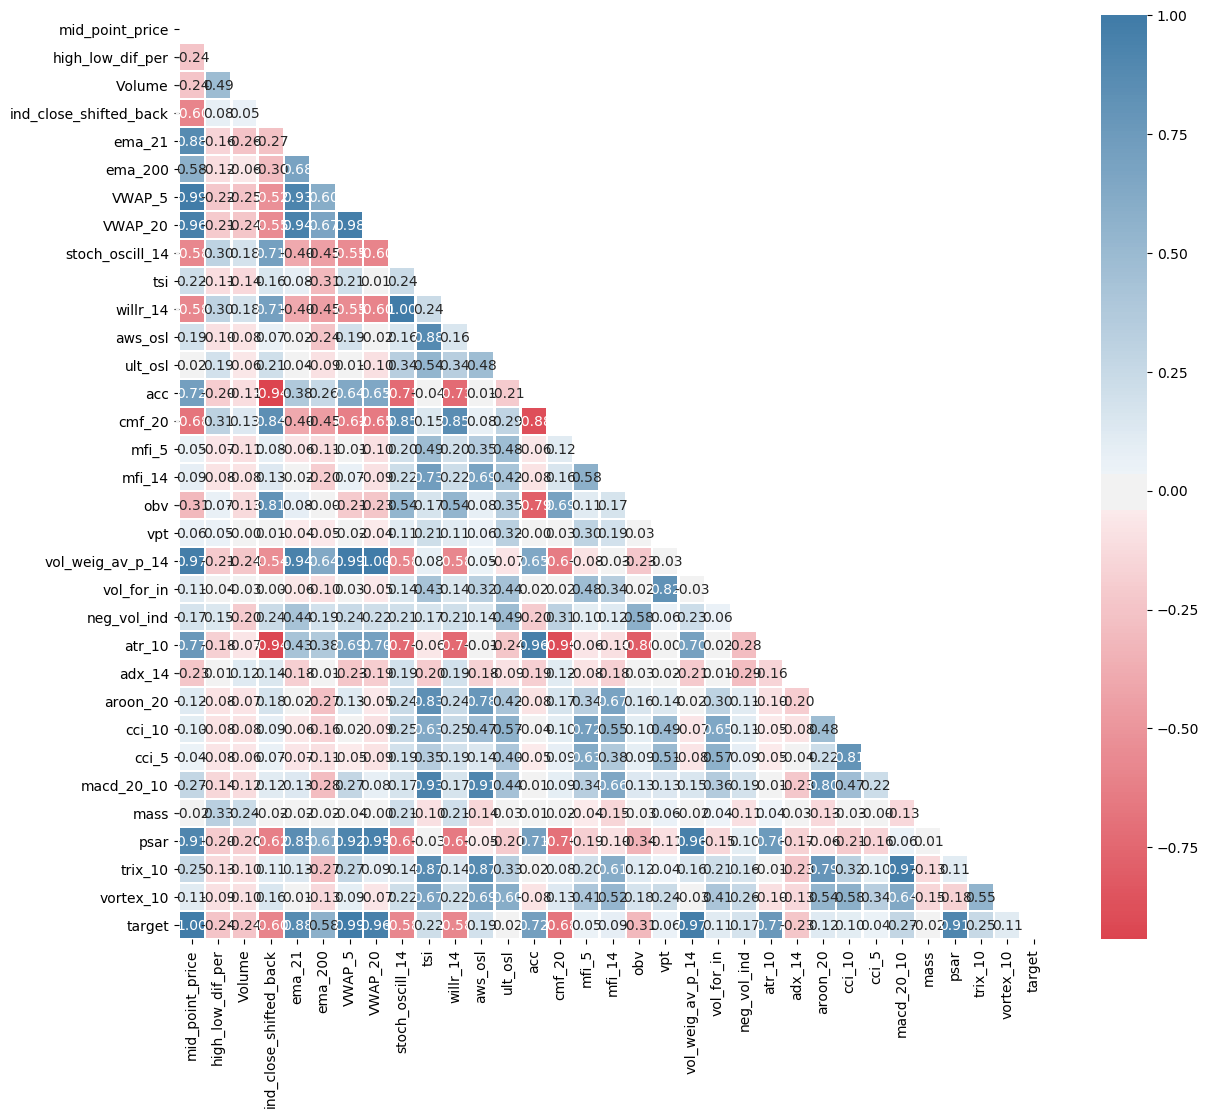

In [27]:
# Correlation Matrix and visualazing it on heat map
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(h_neg=10,h_pos=240,as_cmap=True)
figure = plt.figure(figsize=(14,12))
sns.heatmap(df.corr(), mask=mask,center=0, cmap=cmap, linewidths=1,annot=True, fmt=".2f")
plt.show()

In [28]:
# Generating target value

y = df['target']
y=y[prediction_interval:]

In [29]:
df0=df.copy()

In [30]:
# Generating features (except target, all columns)
df.columns
X = df[['mid_point_price', 'high_low_dif_per', 'Volume',
       'ind_close_shifted_back','ema_21', 'ema_200', 'VWAP_5',
       'VWAP_20', 'stoch_oscill_14', 'tsi', 'willr_14', 'aws_osl', 'ult_osl',
       'acc', 'cmf_20', 'mfi_5', 'mfi_14', 'obv', 'vpt', 'vol_weig_av_p_14',
       'vol_for_in', 'neg_vol_ind', 'atr_10', 'adx_14', 'aroon_20', 'cci_10',
       'cci_5', 'macd_20_10', 'mass', 'psar', 'trix_10', 'vortex_10']].shift(prediction_interval)

In [31]:
X.dropna(inplace=True)

In [32]:
# Define the scaler 
scaler = StandardScaler().fit(X)

# Scale the train set
X = scaler.transform(X)

In [33]:
# Principal component analysis implementation
pca = PCA(n_components=0.95)
X_red = pca.fit_transform(X)
X = pd.DataFrame(X_red)

In [34]:
X=X.values
y=y.values

In [35]:
# Train_test split for features
train_test_split_rate = 0.95
train_test_split_point = int(len(X)*train_test_split_rate)
X_train,y_train = X[:train_test_split_point,:],y[:train_test_split_point,]
X_test,y_test = X[train_test_split_point:,:],y[train_test_split_point:,]


In [36]:
#Some model parameters
learning_rate = 0.01
layer1_units = 256
layer2_units = 128
layer3_units = 64
dropout_rate=0.15
input_dim =X_train.shape[1]
# Describing optimization function
opt = Adam(lr =learning_rate)

# Initialize the model
model = Sequential()

# Add input layer 
model.add(Dense(layer1_units, input_dim=input_dim, activation='relu'))
# Add dropout layer
model.add(Dropout(rate=dropout_rate))
# Add Batchnormalization layer 
model.add(BatchNormalization())

# Add hidden layer
model.add(Dense(layer2_units, activation = 'relu'))
# Add dropout layer
model.add(Dropout(rate=dropout_rate))
# Add Batchnormalization layer 
model.add(BatchNormalization())

# Add hidden layer
model.add(Dense(layer3_units, activation = 'relu'))
# Add dropout layer
model.add(Dropout(rate=dropout_rate))
# Add Batchnormalization layer 
model.add(BatchNormalization())

# Add output layer 
model.add(Dense(1))



In [37]:
# Visualizing model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               3584      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8

In [38]:
# Compile the model
model.compile(optimizer = opt, loss = 'mse', metrics =['mean_absolute_error'])

In [39]:
# Fitting the model
hist = model.fit(X_train,y_train,epochs=60,validation_data=(X_test,y_test),batch_size=32,verbose=0)

In [40]:
# Fitted Price
fitted_price = model.predict(X_train)
fitted_price = pd.DataFrame(fitted_price,columns=['Fitted Price'])

In [41]:
# actual prices for train
ytrain = pd.DataFrame(y_train,columns=['Actual Price'])
ytrain = pd.DataFrame(ytrain,columns=['Actual Price'])

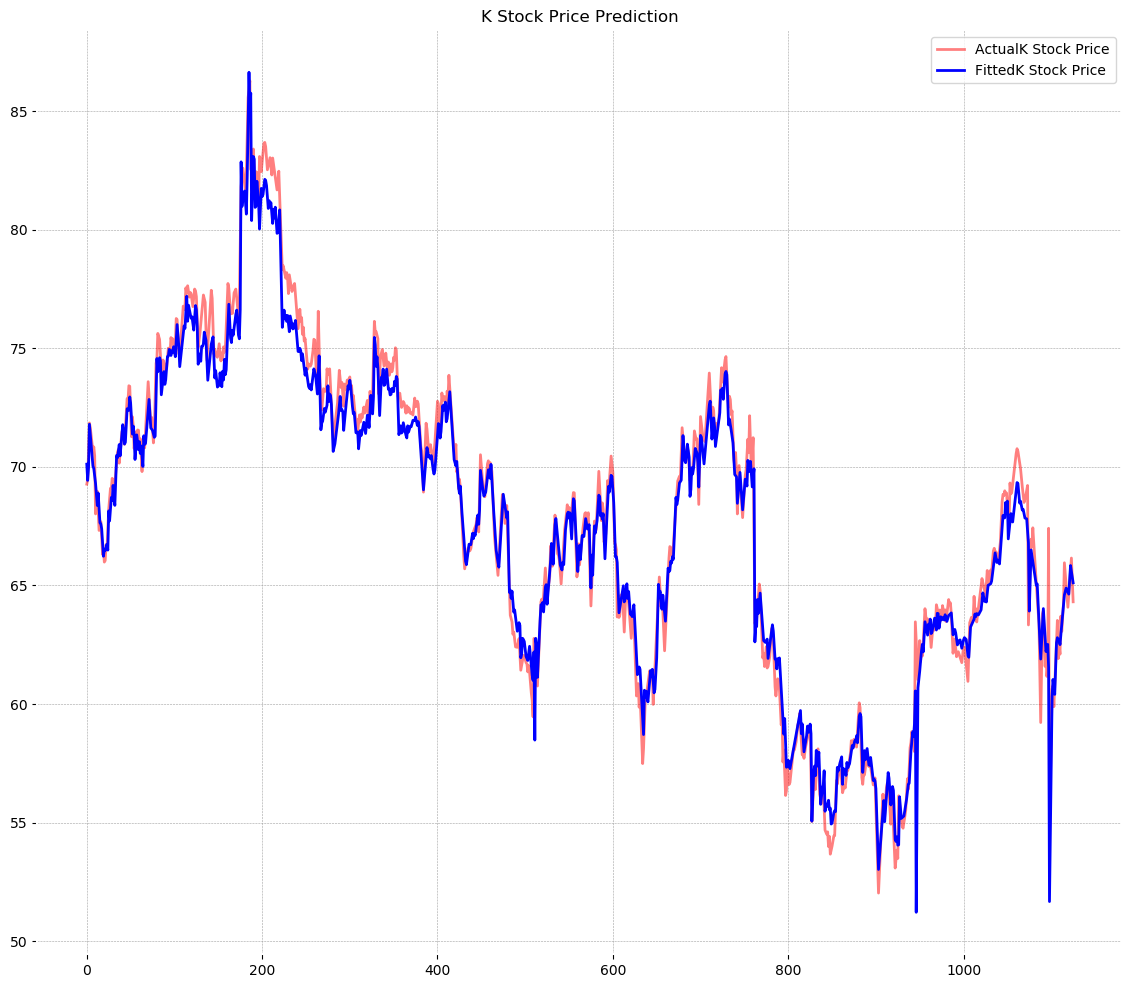

In [42]:
# Visualising the results
plt.figure(figsize=(14,12))
plt.plot(ytrain, color = 'red', label = 'Actual'+ticker+' Stock Price',alpha=0.5)
plt.plot(fitted_price, color = 'blue', label = 'Fitted'+ticker+' Stock Price')
plt.title(ticker+' Stock Price Prediction')
plt.legend()
plt.show()

In [43]:
# Predicted price
predicted_price = model.predict(X_test)
predicted_price = pd.DataFrame(predicted_price,columns=['Predicted Price'])

In [44]:
# Actual prices for test
ytest = pd.DataFrame(y_test,columns=['Actual Price'])
ytest = pd.DataFrame(ytest,columns=['Actual Price'])

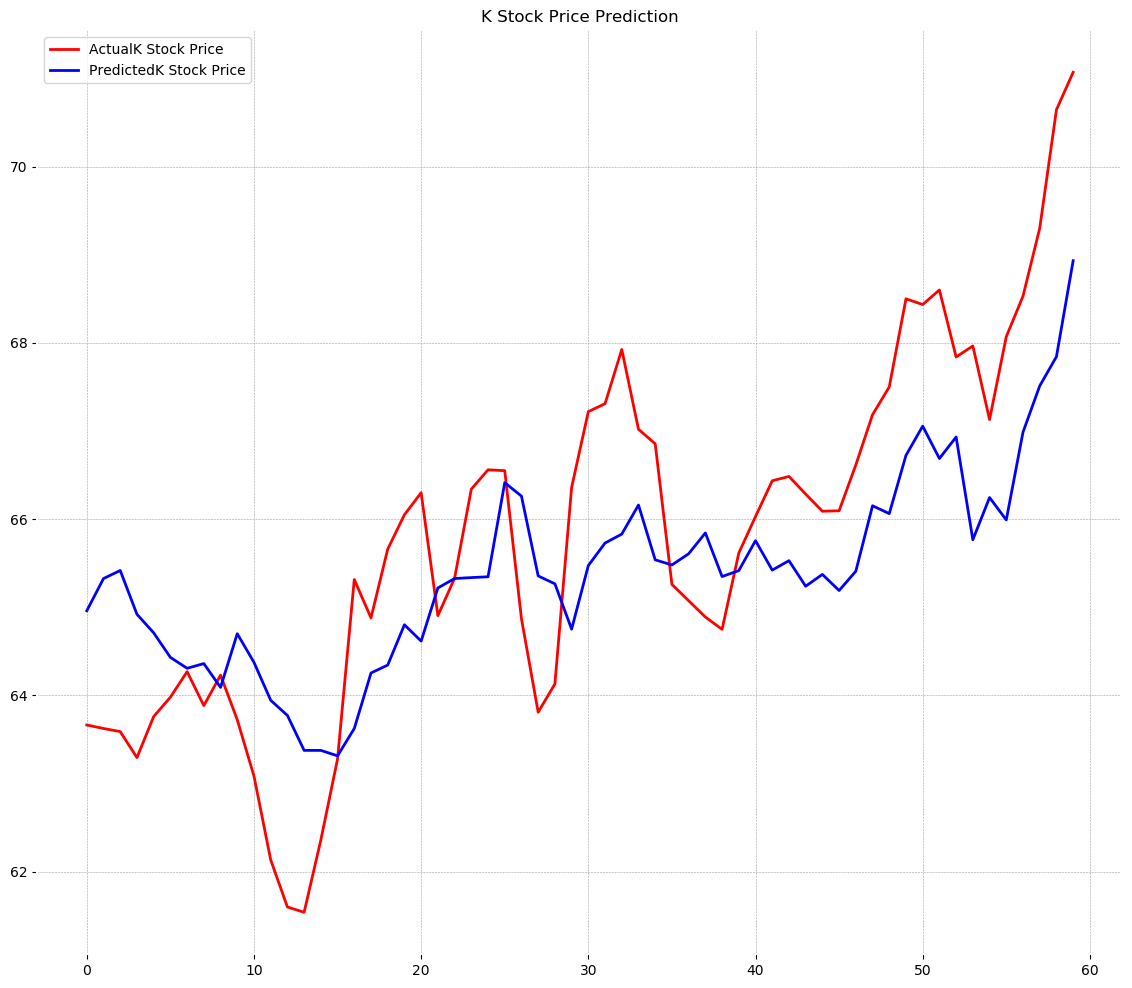

In [45]:
# Visualising the results
plt.figure(figsize=(14,12))
plt.plot(ytest, color = 'red', label = 'Actual'+ticker+' Stock Price')
plt.plot(predicted_price, color = 'blue', label = 'Predicted'+ ticker+' Stock Price')
plt.title(ticker +' Stock Price Prediction')
plt.legend()
plt.show()

In [46]:
# Full pr
actual_prices = ytrain.append(ytest)
aa = len(actual_prices)
df0.dropna(inplace=True)
actual_prices.set_index(df0.index[prediction_interval:],inplace=True)
fitted_price.set_index(df0.index[0:len(ytrain)],inplace=True)
predicted_price.set_index(df0.index[len(ytrain):-prediction_interval],inplace=True)


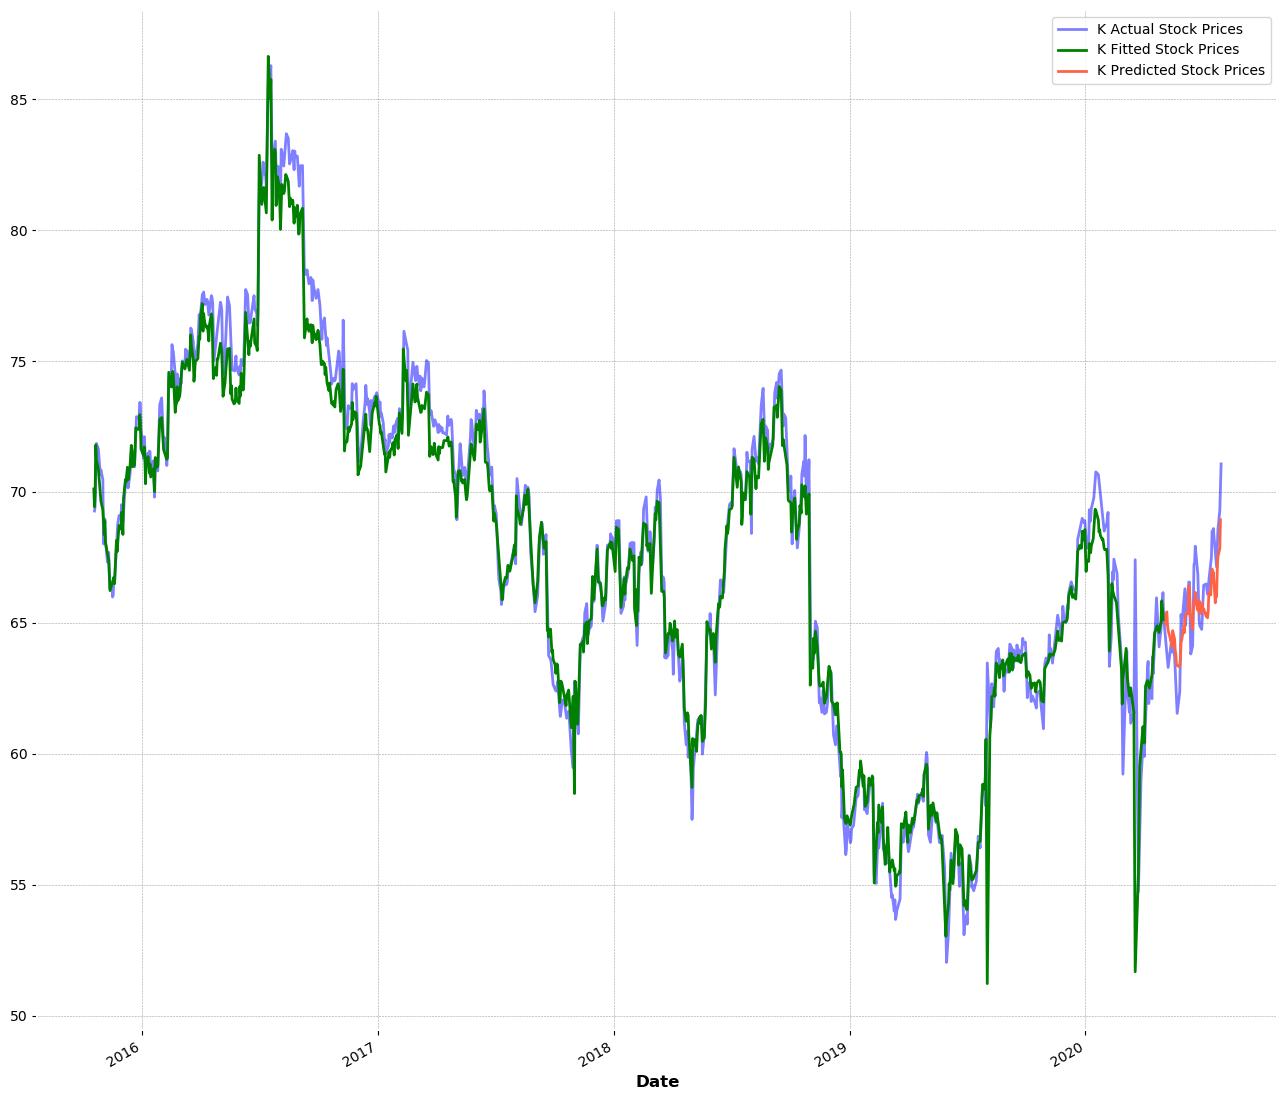

In [47]:
# Full price data visualizing
fig = plt.figure(figsize=(16,15))
ax = fig.add_subplot(111)
actual_prices['Actual Price'].plot(color='blue',label=ticker+' Actual Stock Prices',ax=ax,alpha=0.5)
fitted_price['Fitted Price'].plot(color='green',label=ticker+' Fitted Stock Prices',ax=ax)
predicted_price['Predicted Price'].plot(color='tomato',label=ticker+' Predicted Stock Prices',ax=ax)
plt.legend()
plt.show()

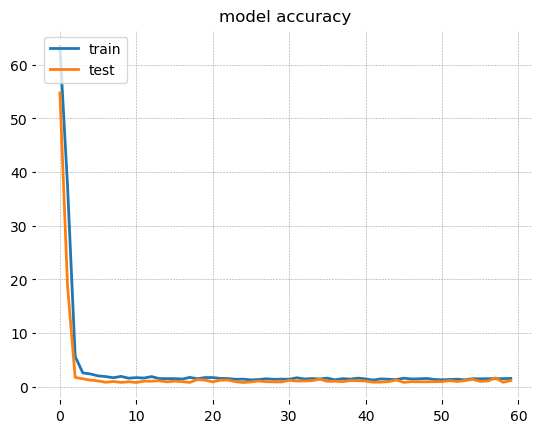

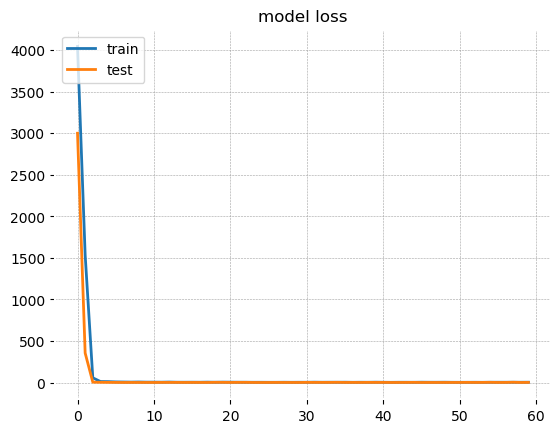

In [48]:
# summarize history for accuracy
plt.plot(hist.history['mean_absolute_error'])
plt.plot(hist.history['val_mean_absolute_error'])
plt.title('model accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [49]:
# Train data evaulatuin 
print("\n")
print("Train Data Mean absolute error (MAE):      %f" % mean_absolute_error(ytrain,fitted_price))
print("Train Data Mean squared error (MSE):       %f" % mean_squared_error(ytrain,fitted_price))
print("Train Data Root mean squared error (RMSE): %f" % np.sqrt(mean_squared_error(ytrain,fitted_price)))
print("Train Data R square (R^2):                 %f" % r2_score(ytrain,fitted_price))



Train Data Mean absolute error (MAE):      0.724221
Train Data Mean squared error (MSE):       0.980935
Train Data Root mean squared error (RMSE): 0.990421
Train Data R square (R^2):                 0.979314


In [50]:
# Test data evaulatuin 
print("\n")
print("Test Data Mean absolute error (MAE):      %f" % mean_absolute_error(ytest,predicted_price))
print("Test Data Mean squared error (MSE):       %f" % mean_squared_error(ytest,predicted_price))
print("Test Data Root mean squared error (RMSE): %f" % np.sqrt(mean_squared_error(ytest,predicted_price)))
print("Test Data R square (R^2):                 %f" % r2_score(ytest,predicted_price))



Test Data Mean absolute error (MAE):      1.177586
Test Data Mean squared error (MSE):       1.794278
Test Data Root mean squared error (RMSE): 1.339506
Test Data R square (R^2):                 0.581077
